In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# sci-kit learn tools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit

In [2]:
df = pd.read_csv("data/diabetic_data.csv")

### Introduction

This dataset is from Virginia Commonwealth University and contains medical data for 101766 diabetes-related patients across 130 U.S. hospitals from 1999 to 2008. There are 49 features which include demographic, medical history, laboratory test, and medication prescription data. The response variable is whether or not the patient was readmitted to the hospital.

In [3]:
(df.columns.values)

array(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
       'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype=object)

In [4]:
df.groupby('readmitted')['encounter_id'].nunique()

readmitted
<30    11357
>30    35545
NO     54864
Name: encounter_id, dtype: int64

### Defining X (predictors) and y (response)

In [5]:
y = df['readmitted']
X = df.loc[:, df.columns != 'readmitted']

### Data Cleaning

* Part 1: Replacing 'questions marks' with NaN in the dataset.
* Part 2: Converting yes/no columns to binary.
* Part 3: Removing columns that are unique id features.

In [6]:
# pt 1: replace question marks with NaN
features = ['weight', 'race', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult']

for f in features:
    X.loc[X[f] == '?', f] = np.NaN


# pt 2: convert two-factor (e.g., yes/no) columns to boolean
X.loc[X.diabetesMed == 'No', 'diabetesMed'] = 0
X.loc[X.diabetesMed == 'Yes', 'diabetesMed'] = 1

X.loc[X.change == 'No', 'change'] = 0
X.loc[X.change == 'Ch', 'change'] = 1

X.loc[X.gender == 'Male', 'gender'] = 0
X.loc[X.gender == 'Female', 'gender'] = 1

X.loc[X.tolbutamide == 'No', 'tolbutamide'] = 0
X.loc[X.tolbutamide == 'Steady', 'tolbutamide'] = 1

# pt 3: 
id_features = ['encounter_id', 'patient_nbr', 'payer_code']

X.drop(id_features, axis = 1, inplace = True)

### Assessing Missing Data

Using Python package [missingno](https://github.com/ResidentMario/missingno), we can easily identify the features with excessive NA's. As you can see in the calcuations below, the features with most NA's are **weight** (~97% NA's) and **medical_specialty** (49% NA's).

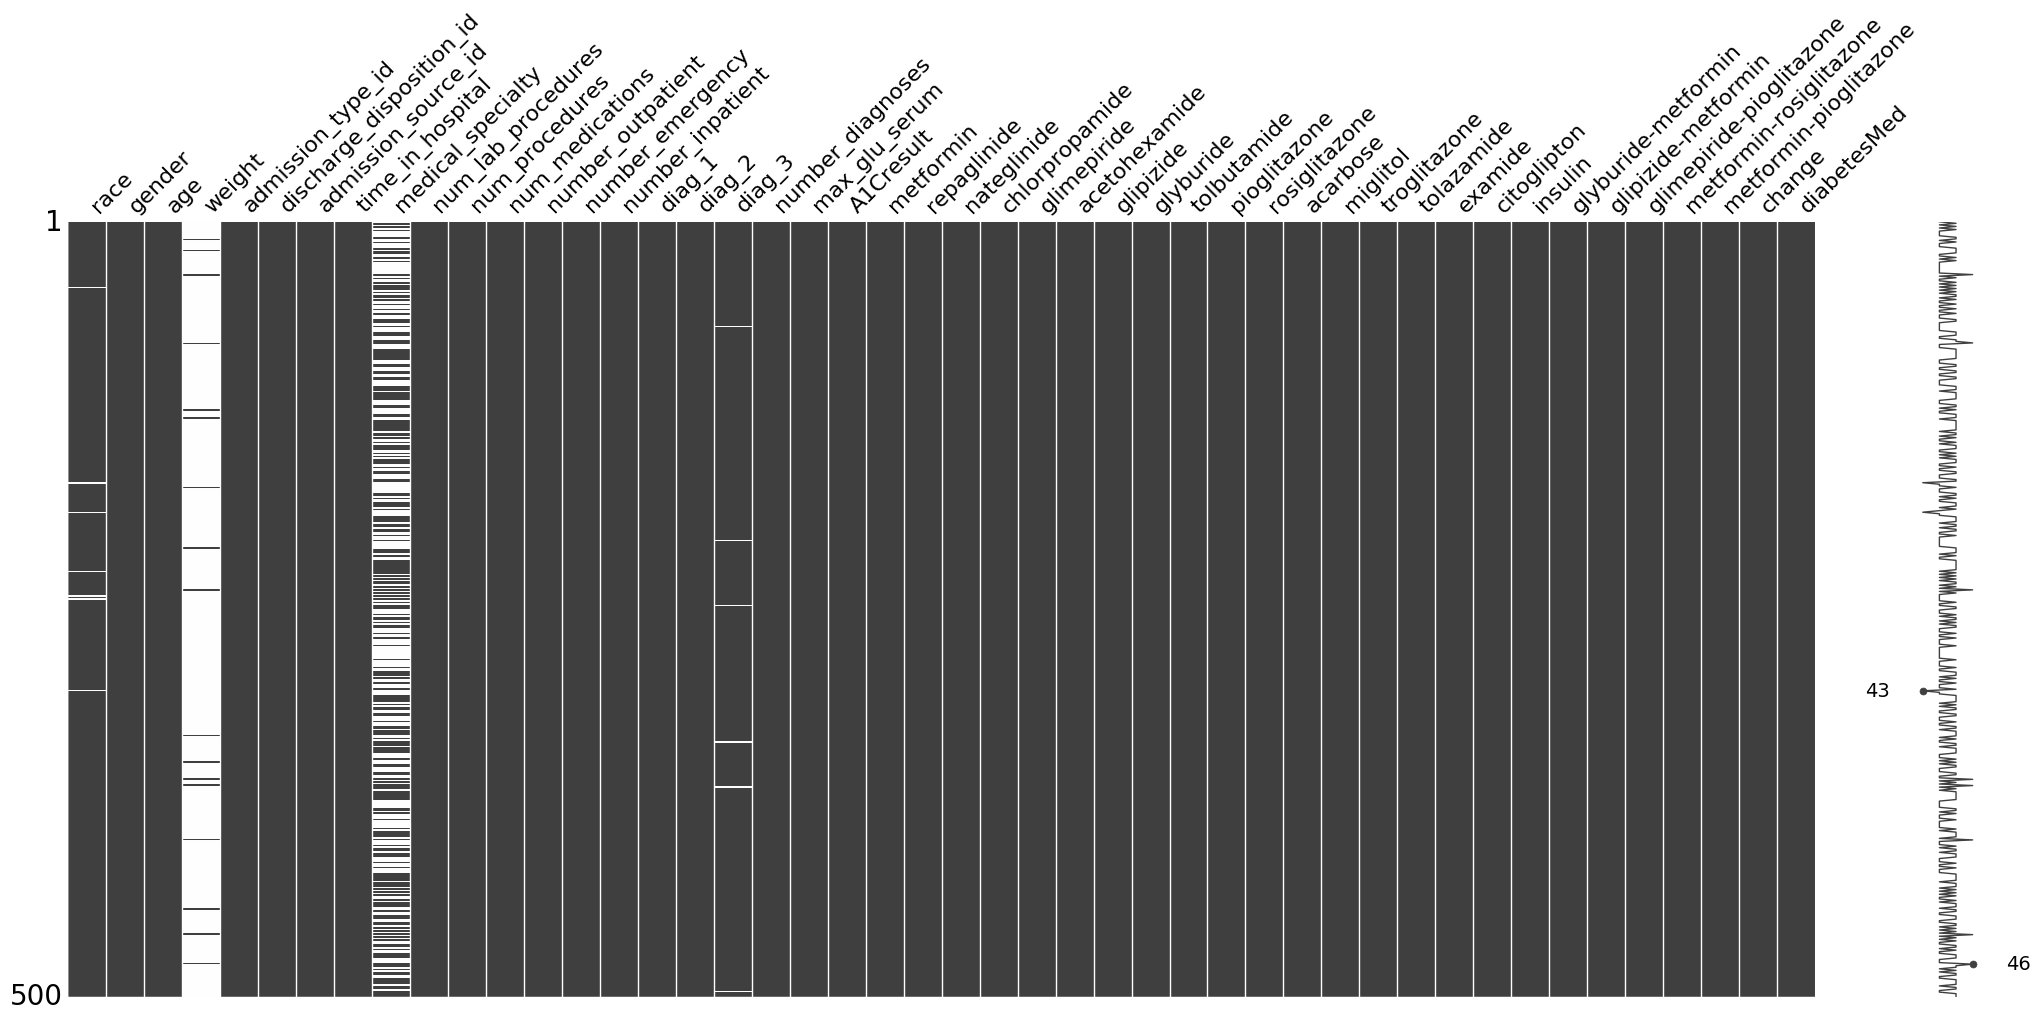

In [7]:
import missingno as msno
%matplotlib inline
msno.matrix(X.sample(500))

In [8]:
print('Proportion of NA values in weight column:',
      X['weight'].isnull().sum()/len(X['weight']))
print('Proportion of NA values in medical_specialty column:',
      X['medical_specialty'].isnull().sum()/len(X['medical_specialty']))
print('Proportion of NA values in race column:',
      X['race'].isnull().sum()/len(X['race']))

Proportion of NA values in weight column: 0.9685847925633315
Proportion of NA values in medical_specialty column: 0.49082208203132677
Proportion of NA values in race column: 0.022335554114340742


In [162]:
levels = df.T.apply(lambda x: x.nunique(), axis=1)
feature_names = list(levels.index)
levels_df = pd.DataFrame({'feature': feature_names, 'level_count': levels})[2:]
levels_df

,feature,level_count
race,race,6
gender,gender,3
age,age,10
weight,weight,10
admission_type_id,admission_type_id,8
discharge_disposition_id,discharge_disposition_id,26
admission_source_id,admission_source_id,17
time_in_hospital,time_in_hospital,14
payer_code,payer_code,18
medical_specialty,medical_specialty,73


In [37]:
# generate visualization for categorical vars 
features = df.columns.values[2:,]

rows = []
for f in features:
    if df[f].nunique() < 10:
        if df[f].dtype not in [np.dtype('float64'), np.dtype('int64')]:
            column = df.groupby(f)['encounter_id'].nunique()
            for i in range(column.shape[0]):
                row = {'feature':f, 'index':i, 'freq':column[i]}
                rows.append(row)

feature_freq = pd.DataFrame.from_dict(rows)

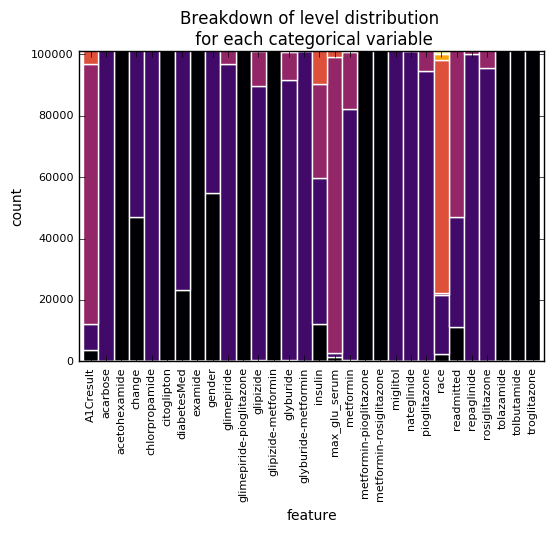

In [167]:
ax = feature_freq.pivot(index='feature',columns='index',values='freq').plot.bar(stacked=True, edgecolor='white', linewidth='1', width=1, cmap='inferno')
ax.legend_.remove()
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_title('Humidity',fontsize= 16)
plt.ylim(0,101000)
plt.title('Breakdown of level distribution \n for each categorical variable')
plt.ylabel('count')
plt.show()

The plot above represents the distribution of category levels for each categorical feature. The bars that are primarily black suggest that those features have one extremely dominant categorical level. Features with one dominant categorical level (99%) are: 
* glimepiride-pioglitazone
* metformin-pioglitazone
* acetohexamide
* metformin-rosiglitazone 
* troglitazone

There are also 2 features which only have one categorical level: `examide`, `citoglipton`. This will also be removed from the feature dataframe. 

In [ ]:
# pt 3: remove columns that are 1) unique ids or 2) have the same value for all patients
features_removed = ['weight', 'examide', 'citoglipton',
                   'glimepiride-pioglitazone', 'metformin-pioglitazone', 
                    'acetohexamide', 'metformin-rosiglitazone', 'troglitazone']

df.drop(features_removed, axis = 1, inplace = True)

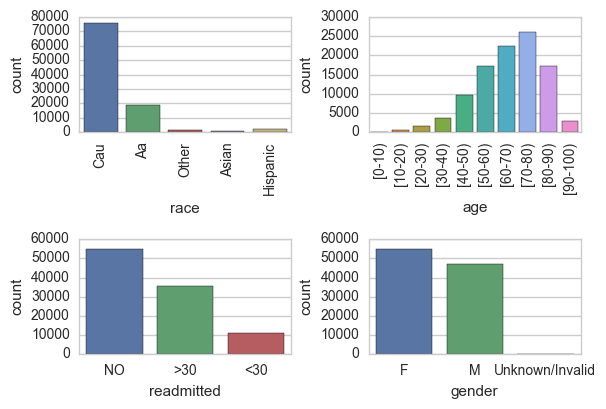

In [87]:
sns.set(style="whitegrid")
plt.subplot(2,2,1)
ax = sns.countplot(x="race", data=df)
plt.xlabel('race')
plt.xticks(rotation=90)
plt.subplot(2,2,2)
ax = sns.countplot(x="age", data=df)
plt.xticks(rotation=90)
plt.subplot(2,2,3)
ax = sns.countplot(x="readmitted", data=df)
plt.subplot(2,2,4)
ax = sns.countplot(x="gender", data=df)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [89]:
items = ['age', 'gender', 'race', 'max_glu_serum', 'A1Cresult', 'medical_specialty']
for i in items:
    pd.get_dummies(X, prefix=[i], columns=[i])
    X.drop([i], axis = 1, inplace = True)

X.drop(['diag_1'], axis = 1, inplace = True)
X.drop(['diag_2'], axis = 1, inplace = True)
X.drop(['diag_3'], axis = 1, inplace = True)

In [90]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

test_error = []
training_error = []

depth = list(range(1,60))

for i in depth:
    clf = RandomForestClassifier(max_depth=i, random_state=42)
    clf.fit(X_train, y_train)
    training_error.append(1-clf.score(X_train, y_train))
    test_error.append(1-clf.score(X_test, y_test))

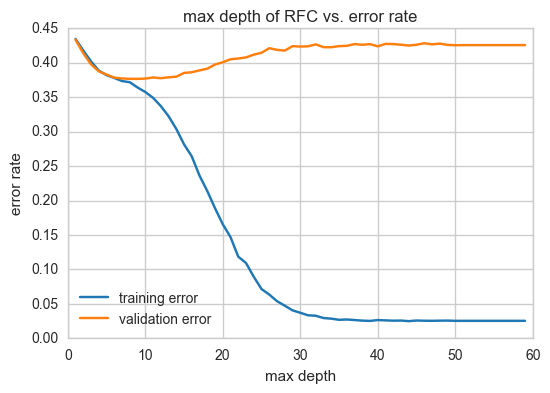

In [91]:
plt.plot(depth, training_error, color='#1f77b4', label="training error")
plt.plot(depth, test_error, color='#ff7f0e', label="validation error")
plt.xlabel('max depth')
plt.ylabel('error rate')
plt.title('max depth of RFC vs. error rate')
plt.legend(loc="best")
plt.show()

In [92]:
clf = RandomForestClassifier(max_depth=9, random_state=42)
clf.fit(X_train, y_train)
print('Training accuracy', clf.score(X_train, y_train))
print('Test accuracy', clf.score(X_test, y_test))

Training accuracy 0.63586231172
Test accuracy 0.62338087723


In [93]:
clf = RandomForestClassifier(max_depth=9, random_state=42)
score = cross_val_score(clf, X, y, cv=10)
score.mean()

0.61798651434640317

Random Forest score after formatting data but before feature selection/feature engineering is 62.4%. 

In [94]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train) 
knn.score(X_test, y_test)

0.56486913021469198

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit, GridSearchCV

split = ShuffleSplit(n_splits=5,test_size=.33,random_state=42)

c = np.arange(-6,2)
c_val = 10.**c

parameters = {'C': c_val}

search = GridSearchCV(LogisticRegression(penalty='l2'), parameters, cv=split)
search.fit(X, y)

print('Best params:', search.best_params_)
print('Best score:', search.best_score_)

# l1 = LogisticRegression(penalty='l1',C=1)
# l1.fit(X_train, y_train)
# #l1.coef_
# l1.score(X_test, y_test)


Best params: {'C': 1.0}
Best score: 0.618026977935


In [1]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(X, y)
print(model.feature_importances_)

3